* This Notebook Contains Whole GPT-2 Model Which Predicts The Next Token. Whole Transformer Block With Each Component Separately Coded in Another Notebook. In this Notebook whole GPT2 Model is Coded and the next word is predicted Using This

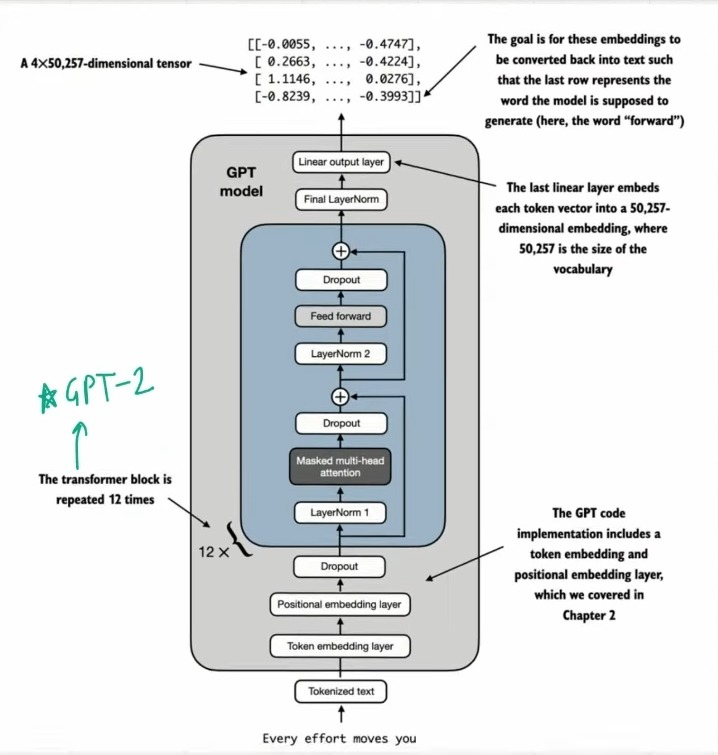

In [1]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length":1024,
    "emb_dim":768,
    "n_layers":12,
    "n_heads":12,
    "drop_rate":0.1,
    "qkv_bias": False
}

In [2]:
import torch
import torch.nn as nn
import importlib
import tiktoken

In [3]:
tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"
batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim = 0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [4]:
class dummyGptModel(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.tokenEmbedding = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"]) #(50257x768)
    self.positionEmbedding = nn.Embedding(cfg["context_length"], cfg["emb_dim"]) #(1024x768)
    self.dropuoutEmbedding = nn.Dropout(cfg["drop_rate"])

    # PlaceHolder for TransformerBlock
    self.transformerBlock = nn.Sequential(
    *[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])]
   )


    # PlaceHolder for LayerNorm
    self.finalNormalization = DummyLayerNorm(cfg["emb_dim"])
    self.out_head = nn.Linear(
        cfg["emb_dim"],
        cfg["vocab_size"], bias = False
    )

  def forward(self, inIdx):
    batchSize, seqLen  = inIdx.shape
    tokenEmbeddings = self.tokenEmbedding(inIdx)
    positionEmbeddings = self.positionEmbedding(torch.arange(seqLen, device = inIdx.device))
    x = tokenEmbeddings + positionEmbeddings
    x = self.dropuoutEmbedding(x)
    x = self.transformerBlock(x)
    x = self.finalNormalization(x)
    logits = self.out_head(x)
    return logits

class DummyTransformerBlock(nn.Module):
  def __init__(self, cfg):
    super().__init__()
  def forward(self, x):
    return x
class DummyLayerNorm(nn.Module):
  def __init__(self, cfg):
    super().__init__()
  def forward(self, x):
    return x

In [5]:
'Layer Normalization'
class LayerNorm(nn.Module):
  def __init__(self, emb_dim):
    super().__init__()
    self.eps = 1e-5
    self.scale = nn.Parameter(torch.ones(emb_dim))
    self.shift = nn.Parameter(torch.zeros(emb_dim))
  def forward(self, x):
    mean = x.mean(dim =-1, keepdim= True) # Mean Along Column
    var = x.var(dim =-1, keepdim= True, unbiased = False) # Variance Along Column
    normalizedX = (x-mean)/torch.sqrt(var+self.eps)  # Eps is small constant to prevent dividing by 0 during normalization
    return self.scale * normalizedX + self.shift

# Scale and shift are two trainable params of same dim as input that LLM automatically adjusts during training and this improves models performance on its training task

'GELU ACTIVATION FUNCTION'
class GELU(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, x):
    return 0.5 * x * (1 + torch.tanh(
        torch.sqrt(torch.tensor(2 / torch.pi)) * (x + 0.044715 * torch.pow(x, 3))
    ))

'Feed Forward Neural Network'
class FeedForward(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(cfg["emb_dim"], 4*cfg["emb_dim"]), #Expansion
        nn.GELU(), # Activation
        nn.Linear(4*cfg["emb_dim"], cfg["emb_dim"]), # Compression
    )

  def forward(self, x):
    return self.layers(x)

In [6]:
'Masked Self Attention'
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x) # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2)

        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec) # optional projection

        return context_vec

In [7]:
'TRANSFORMER BLOCK'
class TransformerBlock(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.attention = MultiHeadAttention(
        d_in = cfg["emb_dim"],
        d_out = cfg["emb_dim"],
        context_length = cfg["context_length"],
        dropout = cfg["drop_rate"],
        num_heads = cfg["n_heads"],
        qkv_bias= cfg["qkv_bias"]
    )
    self.feedforwardNN = FeedForward(cfg)
    self.normalization1 = LayerNorm(cfg["emb_dim"])
    self.normalization2 = LayerNorm(cfg["emb_dim"])
    self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

  def forward(self, x):
    shortcut = x
    x = self.normalization1(x)
    x = self.attention(x)  #Shape [batch_size, num_tokens, emb_size]
    x = self.drop_shortcut(x)
    x = shortcut + x # Add the original input block

    # Shortcut connection for feed forward block
    shortcut = x
    x = self.normalization2(x)
    x = self.feedforwardNN(x)
    x = self.drop_shortcut(x)
    x = shortcut + x
    return x

# ENTIRE GPT MODEL ARCHITECTURE

In [8]:
class GPTModel(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.tokenEmbeddings = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
    self.positionalEmbeddings = nn.Embedding(cfg["context_length"], cfg["emb_dim"]) #(1024x768)
    self.dropuoutEmbeddings = nn.Dropout(cfg["drop_rate"])

    'Transformer Block'
    self.transformerBlock = nn.Sequential(
    *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])]
   )
    'Layer Normalization'
    self.finalNormalization = LayerNorm(cfg["emb_dim"])
    self.out_head = nn.Linear(
        cfg["emb_dim"],
        cfg["vocab_size"], bias = False
    )

  def forward(self, inIdx):
    batchSize, seqLen  = inIdx.shape
    tokenEmbeddings = self.tokenEmbeddings(inIdx)
    positionalEmbeddings = self.positionalEmbeddings(torch.arange(seqLen, device = inIdx.device))
    x = tokenEmbeddings + positionalEmbeddings
    x = self.dropuoutEmbeddings(x)
    x = self.transformerBlock(x)
    x = self.finalNormalization(x)
    logits = self.out_head(x)
    return logits

In [9]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
output = model(batch)
print("Input Batch:\n", batch)
print("Input Dimensions:", batch.shape)
print("Output Batch:\n", output)
print("Output Dimensions:", output.shape)


Input Batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])
Input Dimensions: torch.Size([2, 4])
Output Batch:
 tensor([[[ 0.3612,  0.4223, -0.0712,  ...,  0.3483,  0.4661, -0.2838],
         [-0.1793, -0.5660, -0.9486,  ...,  0.0477,  0.5181, -0.3169],
         [ 0.7120,  0.0332,  0.1085,  ...,  0.1017, -0.4326, -0.2553],
         [-1.0076,  0.3419, -0.1190,  ...,  0.7195,  0.4023,  0.0532]],

        [[-0.2565,  0.0901,  0.0335,  ...,  0.2658,  0.4454, -0.6806],
         [ 0.1229,  0.3653, -0.2074,  ...,  0.7705,  0.2710,  0.2245],
         [ 1.0558,  1.0318, -0.2799,  ...,  0.6935,  0.3205, -0.3178],
         [-0.1567,  0.3928,  0.3288,  ...,  1.2630, -0.1859,  0.0388]]],
       grad_fn=<UnsafeViewBackward0>)
Output Dimensions: torch.Size([2, 4, 50257])


In [10]:
totalParams = sum(p.numel() for p in model.parameters())
print(f"Total Parameters: {totalParams:,}")

Total Parameters: 163,009,536


In [11]:
print("Token Embedding Layer Shape:", model.tokenEmbeddings.weight.shape)
print("Output Layer Shape", model.out_head.weight.shape)

Token Embedding Layer Shape: torch.Size([50257, 768])
Output Layer Shape torch.Size([50257, 768])


In [12]:
totalParamGpt2 = totalParams - sum(p.numel() for p in model.out_head.parameters())
print(f"Total Parameters: {totalParamGpt2:,}")

Total Parameters: 124,412,160


* Computing Memory Requirements for the 163 million parameters in our GPTModel object

In [13]:
totalSizeBytes = totalParams*4
totalSizemb = totalSizeBytes/(1024*1024)
print(f"Total Size : {totalSizemb: .2f} MB")

Total Size :  621.83 MB


# GENERATING TEXT FROM OUTPUT TOKENS

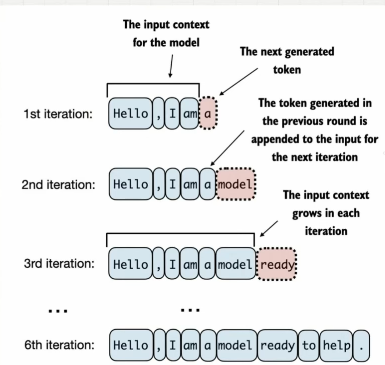

* S1) Extract Last Vector
* S2) Apply SOFTMAX to convert logits into probabilities which sums upto 1
* S3) Identify the index Position(token ID) of largest Probability Value and decode this token ID
* S4) Append TOKEN ID to the previous inputs for the next word

--> NOTE: Model Training is Not Done so Right Now it will only generate some random words/tokens

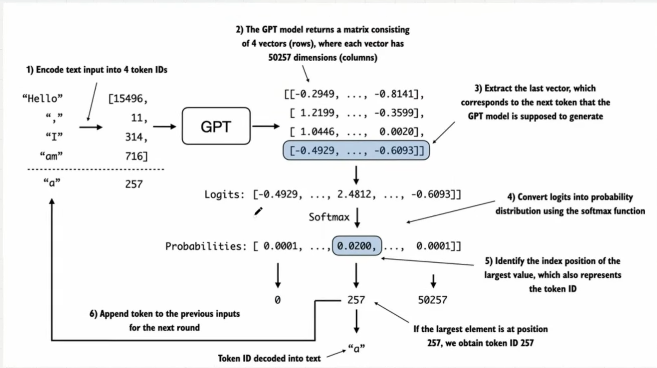

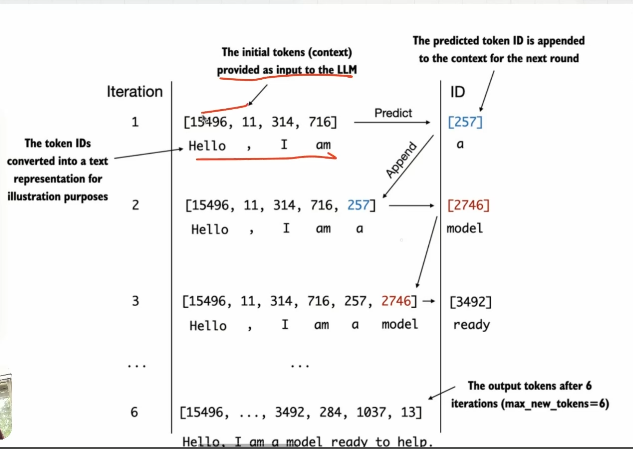

In [24]:
def generateText(model, idx, maxNewTokens, contextSize):
    # idx is (batch, numTokens) array of indices in the current context
    for _ in range(maxNewTokens):
        # Crop the current context if it exceeds the supported size
        idxCond = idx[:, -contextSize:]

        # Predictions
        with torch.no_grad():
            logits = model(idxCond)  # (batch, numTokens, vocabSize)

        # S1) Extract last vector
        logits = logits[:, -1, :]  # (batch, vocabSize)

        # S2) Apply softmax to get probabilities
        probs = torch.softmax(logits, dim=-1)

        # S3) Choose the highest probability
        idxNext = torch.argmax(probs, dim=-1, keepdim=True)  # (batch, 1)

        # S4) Append the new token to the sequence
        idx = torch.cat((idx, idxNext), dim=1)  # (batch, numTokens+1)

    return idx


In [22]:
startingContext = "Hello, I am"
encoded = tokenizer.encode(startingContext)
print("Encoded:", encoded)
encodedTensor = torch.tensor(encoded).unsqueeze(0)
print("Tensor:", encodedTensor)
print(encodedTensor.shape)

Encoded: [15496, 11, 314, 716]
Tensor: tensor([[15496,    11,   314,   716]])
torch.Size([1, 4])


In [26]:
model.eval()
output = generateText(
    model = model,
    idx = encodedTensor,
    maxNewTokens= 6,
    contextSize = GPT_CONFIG_124M["context_length"]
)
print("Output:", output)
print("Output Length:", len(output[0]))


Output: tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961, 42348,  7267]])
Output Length: 10


In [27]:
decodedText = tokenizer.decode(output[0].tolist())
print(decodedText)

Hello, I am Featureiman Byeswickattribute argue
